In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports and Global Variables

In [2]:
from utilties.imports import *

In [3]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'
x_train, y_train, x_valid, y_valid = get_data(MNIST_URL)
number_hidden = 50
batch_size = 64
num_categories = y_train.max().item()+1
loss_function = F.cross_entropy

In [4]:
training_ds = Dataset(x_train, y_train)
validation_ds = Dataset(x_valid, y_valid)
train_dl = DataLoader(training_ds, batch_size, shuffle = True) #random sampler
valid_dl = DataLoader(validation_ds, batch_size*2, shuffle = False) #sequential sampler

In [5]:
model, optimizer = get_model(train_dl)
runner = Runner([AvgStatsCallback([accuracy])])

In [6]:
runner.fit(3, model, optimizer, loss_function, train_dl,valid_dl)

train: [0.31354771484375, tensor(0.9031)]
valid: [0.16224268798828126, tensor(0.9528)]
train: [0.146930400390625, tensor(0.9556)]
valid: [0.14608388671875, tensor(0.9560)]
train: [0.11519748046875, tensor(0.9645)]
valid: [0.11860296630859375, tensor(0.9666)]


## Two New Callbacks: 
- Recorder: tracks loss and the scheduled learning rate
- ParameterScheduler: used to schedule hyperparameters 
    - Parameters must be registered in the state_dict of the optimizer

In [7]:
class Recorder(Callback):
    def begin_fit(self):
        self.learn_rates = []
        self.losses = []
        
    def after_batch(self):
        self.learn_rates.append(self.opt.param_groups[-1]['lr'])#appends the learning rate in the optimizer
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lrs(self):
        plt.plot(self.learn_rates)
        
    def plot_losses(self):
        plt.plot(self.losses)
        
class ParameterScheduler(Callback):
    _order = 1
    def __init__(self, parm_name, schedule_func):
        self.parameter_name = parm_name
        self.schedule_function = schedule_func
        
    def set_parameter(self):
        for p_group in self.opt.param_groups:
            p_group[self.parameter_name] = self.schedule_function(self.n_epochs/self.epochs)
            
    def begin_batch(self):
        if self.in_train:
            self.set_parameter()

### Parameter Scheduling Example: Linear Scheduler

In [8]:
def linear_schedule(start, end):
    def _inner(start, end, pos):
        return start + pos*(end-start)
    return partial(_inner, start, end)

### Improved Linear Scheduler

In [9]:
def annealer(f): #decorator used to define anneling functions, that can be passed to the ParameterSchedule set_params()
    def _inner(start, end):
        return partial(f, start, end)
    return _inner

In [10]:
## Scheduling Function Variants
@annealer
def linear_scheduler(start, end, position):
    return start+position*(end-start)

#cosine annealing from this paper: https://arxiv.org/pdf/1608.03983.pdf
@annealer
def cosine_scheduler(start, end, position):
    return start + (1 + math.cos(math.pi*(1-position))) * (end-start) / 2

@annealer
def exponential_scheduler(start, end, position):
    return start * (end/start) ** position

@annealer
def no_scheduler(start, end, position):
    return start

lin = linear_scheduler(1,2)
cos = cosine_scheduler(1,2)
expn = exponential_scheduler(1,2)
print("Linear: %f\nCosine: %f\nExponential: %f"%(lin(0.58), cos(0.58), expn(0.58))) #58% of the way through training

Linear: 1.580000
Cosine: 1.624345
Exponential: 1.494849


## Plotting Schedulers

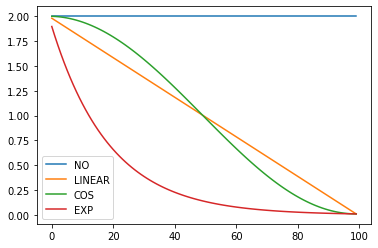

In [11]:
#monkey patching pytorch tensors for plotting with mathplotlib
torch.Tensor.ndim = property(lambda x: len(x.shape))

annealings = "NO LINEAR COS EXP".split()
t_range = torch.arange(0,100)
p = torch.linspace(0.01, 1, 100)

functions = [no_scheduler, linear_scheduler, cosine_scheduler, exponential_scheduler]
for fn, t in zip(functions, annealings):
    f = fn(2, 1e-2)
    plt.plot(t_range, [f(o) for o in p], label = t)
plt.legend()

### Combining Schedulers Example

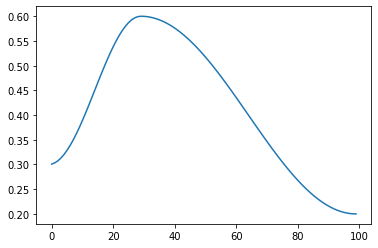

In [12]:
def cosine_1cycle_annealing(start, high, end):
    return [cosine_scheduler(start,high), cosine_scheduler(high, end)]

def combine_schedules(pcts, schedules):
    assert sum(pcts) == 1. #ratios always add up to 1
    pcts = tensor([0] + convert_to_list(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        index = (pos >= pcts).nonzero().max()
        actual_position = (pos - pcts[index])/ (pcts[index+1]-pcts[index])
        return schedules[index](actual_position)
    return _inner

sched = combine_schedules([0.3, 0.7], [cosine_scheduler(0.3, 0.6), cosine_scheduler(0.6, 0.2)]) 
plt.plot(t_range, [sched(o) for o in p])

In [16]:
callback_funcs = [Recorder,
                  partial(AvgStatsCallback,accuracy),
                  partial(ParameterScheduler, 'lr', sched)]
runner = Runner(cb_functions= callback_funcs)
runner.fit(3, model, optimizer, loss_function, train_dl, valid_dl)

train: [0.08983322265625, tensor(0.9721)]
valid: [0.11784088134765625, tensor(0.9659)]
train: [0.08616021484375, tensor(0.9725)]
valid: [0.149839794921875, tensor(0.9583)]
train: [0.0561878173828125, tensor(0.9826)]
valid: [0.09040316772460938, tensor(0.9734)]


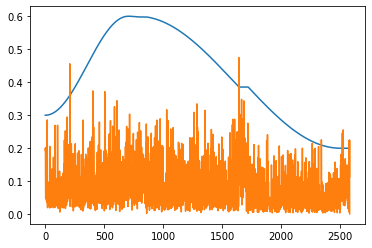

In [20]:
runner.recorder.plot_lrs()
runner.recorder.plot_losses()